# Network-based *in silico* drug efficacy screening

This notebook reproduces the proximity-based analysis in the the manuscript. Known drug-disease associations, proximity and relative efficacy values are given in Supplementary Data 1 (the information is combined in "proximity.dat").

In [1]:
# Read the data file containing information on analyzed drug-disease pairs 
# flag: True (known) | CT (unknown & in trials) | False (unknown & not in trials)
# d: average shortest path length from drug targets to closest disease gene
# z: proximity value 
# re: relative efficacy value
file.name = "proximity.dat"
d = read.table(file.name, header=T)
draw.plots = T #F

## Area under ROC Curve

***AUC using proximity***

In [2]:
#require(pROC)
f = data.frame(V1=-d$z, V2=ifelse(d$flag=="True", 1, 0))
#auc = auc(f$V2, f$V1)
#print(sprintf("AUC: %.3f", auc))
require(ROCR)
pred = prediction(f$V1, f$V2)
perf = performance(pred, "auc")
print(sprintf("AUC: %.3f", perf@y.values[[1]]))
# Draw the ROC curve (not in the main text)
#if(draw.plots) {
#    perf = performance(pred, "tpr", "fpr")
#    plot(perf)
#}

Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



[1] "AUC: 0.657"


***AUC using proximity based similarity***

In [3]:
file.name = "proximity_similarity.dat"
e = read.table(file.name, header=T)
f = data.frame(V1=e$s, V2=ifelse(e$flag=="True", 1, 0))
#auc = auc(f$V2, f$V1)
#print(sprintf("AUC: %.3f", auc))
pred = prediction(f$V1, f$V2)
perf = performance(pred, "auc")
print(sprintf("AUC: %.3f", perf@y.values[[1]]))
# Draw the ROC curve (not in the main text)
#if(draw.plots) {
#    perf = performance(pred, "tpr", "fpr")
#    plot(perf)
#}

[1] "AUC: 0.814"


## Drug target degree vs shortest path and proximity
***Correlation between min shortest path length and drug target degree***

In [4]:
e = d[d$flag == "True",]
selected = "d"
variable = "d.target"
a = cor.test(e[,variable], e[,selected], method="spearman")
print(sprintf("%s vs %s: %.3f %e", selected, variable, a$estimate, a$p.value))

Warning message:
In cor.test.default(e[, variable], e[, selected], method = "spearman"): Cannot compute exact p-value with ties

[1] "d vs d.target: -0.463 8.572116e-23"


***Correlation between proximity and drug target degree***

In [5]:
e = d[d$flag == "True",]
selected = "z"
variable = "d.target"
a = cor.test(e[,variable], e[,selected], method="spearman")
print(sprintf("%s vs %s: %.3f %e", selected, variable, a$estimate, a$p.value))

Warning message:
In cor.test.default(e[, variable], e[, selected], method = "spearman"): Cannot compute exact p-value with ties

[1] "z vs d.target: -0.010 8.429820e-01"


## Proximity cutoff

[1] "Cutoff: -0.1502"
[1] "Sens: 0.5896 Spec: 0.5995"


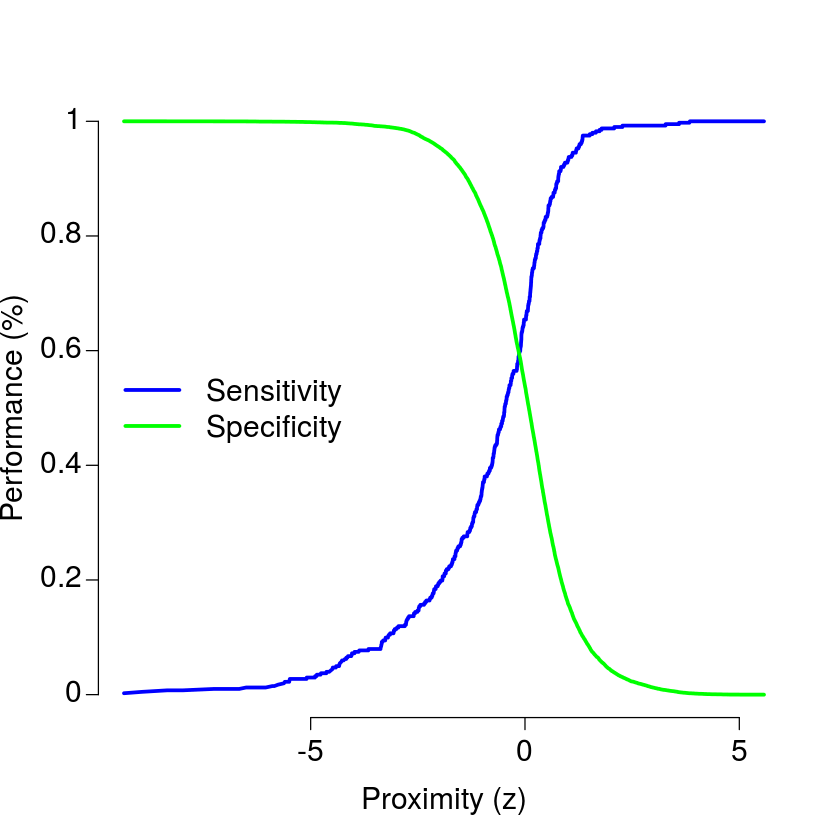

In [6]:
require(ROCR)
f = data.frame(V1=-d$z, V2=ifelse(d$flag=="True", 1, 0))
pred = prediction(f$V1, f$V2)
perf = performance(pred, "sens")
x = -perf@x.values[[1]]
a = perf@y.values[[1]]
# Draw sensitivity - specificity curve
if(draw.plots) {
    plot(x, a, col="blue", type="l", bty="n", lwd=3, xlab="Proximity (z)", ylab="Performance (%)", yaxt='n', cex.lab=1.5, cex.axis=1.5)
    axis(2, labels=F)
    text(par("usr")[1]-0.1, y = seq(0, 1, by=0.2), labels = seq(0, 1, by=0.2), pos=2, cex=1.5, xpd=T)
    perf = performance(pred, "spec")
    b = perf@y.values[[1]]
    lines(x, b, col="green", lwd=3)
    legend("left", legend=c("Sensitivity", "Specificity"), col=c("blue", "green"), lty=c(1,1), lwd=c(3,3), bty="n", cex=1.5)
}
i = which.max(abs(a - b) <= 0.01)
print(sprintf("Cutoff: %.4f", x[i]))
print(sprintf("Sens: %.4f Spec: %.4f", a[i], b[i]))

# Set z cutoff for further analysis
Z.CUTOFF = -0.15
cutoff = Z.CUTOFF

## Enrichment of known and clinical trial drug-disease pairs

Loading required package: ggplot2


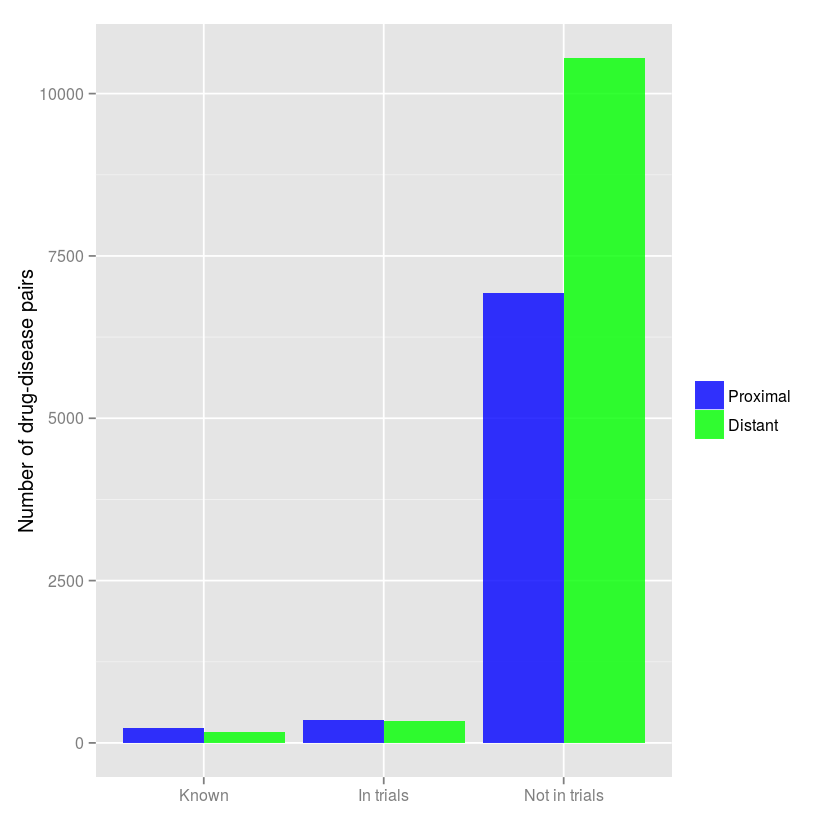

In [7]:
e = d
# Draw the bar plots
if(draw.plots) {
    require(ggplot2)
    # Enrichment plot
    e$close = ifelse(e$z<=cutoff, "Proximal", "Distant")
    e$close = factor(e$close, c("Proximal", "Distant"))
    e$known = ifelse(e$flag == "True", "Known", ifelse(e$flag=="CT", "In trials", "Not in trials"))
    e$known = factor(e$known, c("Known", "In trials", "Not in trials"))
    e$ct = ifelse(e$flag == "CT", "in CT", "not in CT")
    p = ggplot(data=e, aes(known)) + geom_bar(aes(fill=close), position="dodge", alpha=0.8) + labs(x="", y="Number of drug-disease pairs") + guides(fill=guide_legend("")) + scale_fill_manual(values=c("blue", "green", "orange"))
    print(p)
}

***Known vs Unknown (in trails and not in trials)***

In [8]:
# Enrichment of known among proximal and distant at proximity cutoff
method = "z"
cutoff = Z.CUTOFF
x=e[e$flag=="True", ]
y=e[e$flag!="True", ]
a = sum(x[[method]]<=cutoff, na.rm=T)
b = sum(y[[method]]<=cutoff, na.rm=T)
contigency = matrix(c(a, nrow(x)-a, b, nrow(y)-b), 2, 2)
s = fisher.test(contigency)
print(sprintf("z <= %.2f: OR = %.3f P = %s", cutoff, s$estimate, s$p.value))
print(contigency)
print(sum(contigency))

[1] "z <= -0.15: OR = 2.149 P = 5.05772931583593e-14"
     [,1]  [,2]
[1,]  237  7276
[2,]  165 10886
[1] 18564


***In trials vs not in trials***

In [9]:
# CT enrichment
method = "z"
cutoff = Z.CUTOFF
x=e[e$flag=="CT", ]
y=e[e$flag=="False", ]
a = sum(x[[method]]<=cutoff, na.rm=T)
b = sum(y[[method]]<=cutoff, na.rm=T)
contigency = matrix(c(a, nrow(x)-a, b, nrow(y)-b), 2, 2)
s = fisher.test(contigency)
print(sprintf("CT vs Uknown z <= %.2f: OR = %.3f P = %s", cutoff, s$estimate, s$p.value))
print(contigency)
print(sum(contigency))

[1] "CT vs Uknown z <= -0.15: OR = 1.577 P = 4.53509967769708e-09"
     [,1]  [,2]
[1,]  353  6923
[2,]  341 10545
[1] 18162


***Known vs Unknown of significantly proximal***

In [10]:
# Enrichment of significantly proximal
method = "z"
cutoff = -2
x=e[e$flag=="True", ]
y=e[e$flag!="True", ]
a = sum(x[[method]]<=cutoff, na.rm=T)
b = sum(y[[method]]<=cutoff, na.rm=T)
contigency = matrix(c(a, nrow(x)-a, b, nrow(y)-b), 2, 2)
s = fisher.test(contigency)
print(sprintf("z <= %.2f: OR = %.3f P = %s", cutoff, s$estimate, s$p.value))
print(contigency)
print(sum(contigency))

[1] "z <= -2.00: OR = 5.198 P = 2.59524384154343e-27"
     [,1]  [,2]
[1,]   79   816
[2,]  323 17346
[1] 18564


***Pairs in which drug targets are disease genes***

In [11]:
# Enirchment of pairs in which the drug targets are disease genes
method = "d"
cutoff = 0
a = sum(x[[method]]<=cutoff, na.rm=T) # n.overlap
b = sum(y[[method]]<=cutoff, na.rm=T) 
contigency = matrix(c(a, nrow(x)-a, b, nrow(y)-b), 2, 2)
s = fisher.test(contigency)
print(sprintf("n.overlap >= %.2f: OR = %.3f P = %s", cutoff, s$estimate, s$p.value))
print(contigency)
print(sum(contigency))

[1] "n.overlap >= 0.00: OR = 7.691 P = 3.2268633750102e-10"
     [,1]  [,2]
[1,]   18   110
[2,]  384 18052
[1] 18564


***Pairs with at least one overlapping drug target and disease gene***

In [12]:
# Enirchment of pairs with at least one overlapping drug target and disease gene
method = "n.overlap"
cutoff = 0
a = sum(x[[method]]>cutoff, na.rm=T) # n.overlap
b = sum(y[[method]]>cutoff, na.rm=T) 
contigency = matrix(c(a, nrow(x)-a, b, nrow(y)-b), 2, 2)
s = fisher.test(contigency)
print(sprintf("n.overlap >= %.2f: OR = %.3f P = %s", cutoff, s$estimate, s$p.value))
print(contigency)
print(sum(contigency))

[1] "n.overlap >= 0.00: OR = 6.575 P = 5.22828087570084e-27"
     [,1]  [,2]
[1,]   62   490
[2,]  340 17672
[1] 18564


## Proximity and drug efficacy

In [13]:
method = "z"
cutoff = Z.CUTOFF

# Read drug label / palliativeness info 
g = read.table("palliative.csv", header=T)
g = g[-(g$label==-1),]

e = d[d$flag=="True",]
e$re = 100*e$re
e = e[order(e$disease, e$group.name),]
e$close = ifelse(e$z<=cutoff, "Proximal", "Distant")
e$palliative = ifelse(g$palliative>0.5, "Palliative", "Non-palliative")
e$label = ifelse(g$label==1, "Label", "Off-label")
e$type = ifelse(e$label=="Label", ifelse(e$palliative=="Palliative", "Palliative", "Non-palliative"), "Off-label")

*** Relative efficacy (RE) of palliative pairs vs non-palliative and off-label***

[1] "RE non-palliative ~ palliative: 77.777 32.445 7.28623675925775e-05"
[1] "RE off-label ~ palliative: 77.011 32.445 0.000755952511093244"


Warning message:
: Removed 198 rows containing non-finite values (stat_ydensity).Warning message:
: Removed 198 rows containing missing values (stat_summary).Warning message:
: Removed 198 rows containing missing values (geom_point).

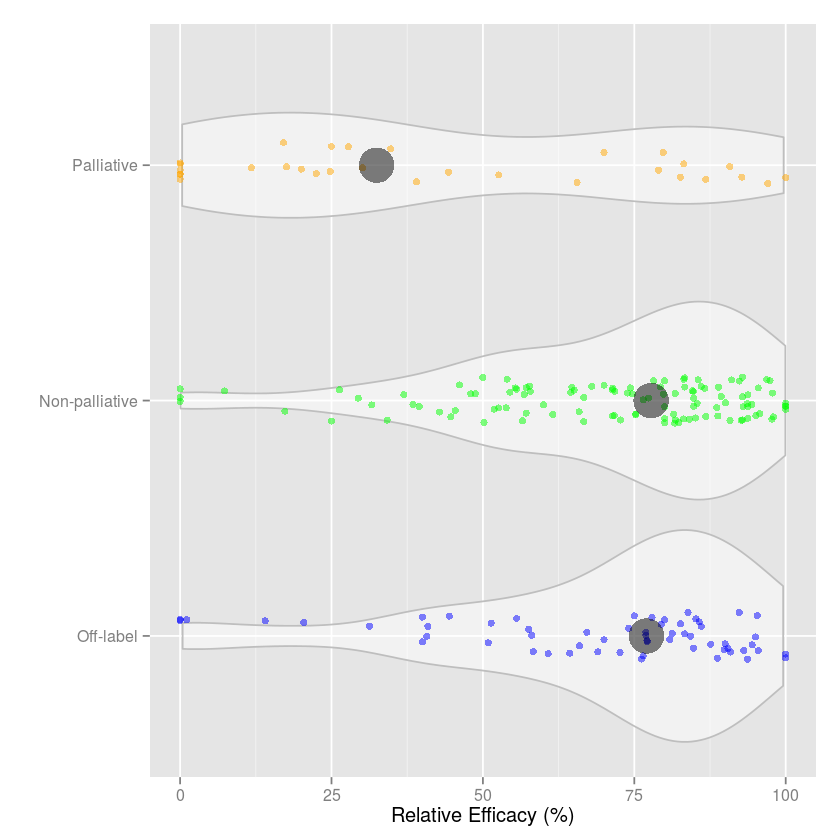

In [14]:
# RE among palliative vs non-palliaitve and off-label
x = e[e$type=="Non-palliative",]
y = e[e$type=="Palliative",]
a = wilcox.test(x$re, y$re, alternative="greater")
print(sprintf("RE non-palliative ~ palliative: %.3f %.3f %s", median(x$re, na.rm=T), median(y$re, na.rm=T), a$p.value))
x = e[e$type=="Off-label",]
a = wilcox.test(x$re, y$re, alternative="greater")
print(sprintf("RE off-label ~ palliative: %.3f %.3f %s", median(x$re, na.rm=T), median(y$re, na.rm=T), a$p.value))

f = e
f$type = factor(f$type, levels=rev(c("Palliative", "Non-palliative", "Off-label")))
if(draw.plots) {
    # Type vs RE
    #p = draw.violinplot(f, "type", "re", "", "Relative Efficacy (%)")
    variable = "type"
    value = "re"
    y.lab = "Relative Efficacy (%)"
    p = ggplot(data=f, aes_string(x=variable, y=value)) + geom_violin(alpha=0.5, color="gray") 
    p = p + geom_jitter(alpha=0.5, aes_string(color=variable), position = position_jitter(width = 0.1)) 
    p = p + stat_summary(fun.y="median", geom='point', color='black', size=10, alpha=0.5) + coord_flip() 
    p = p + scale_color_manual(values=c("blue", "green", "orange"))
    p = p + labs(y = y.lab, x="") + guides(color=F) 
    print(p)
}

*** Proximity of palliative pairs vs non-palliative and off-label***

[1] "z non-palliative ~ palliative: -0.679 0.083 4.00857071698135e-05"
[1] "z off-label ~ palliative: -0.278 0.083 0.0216446520878613"


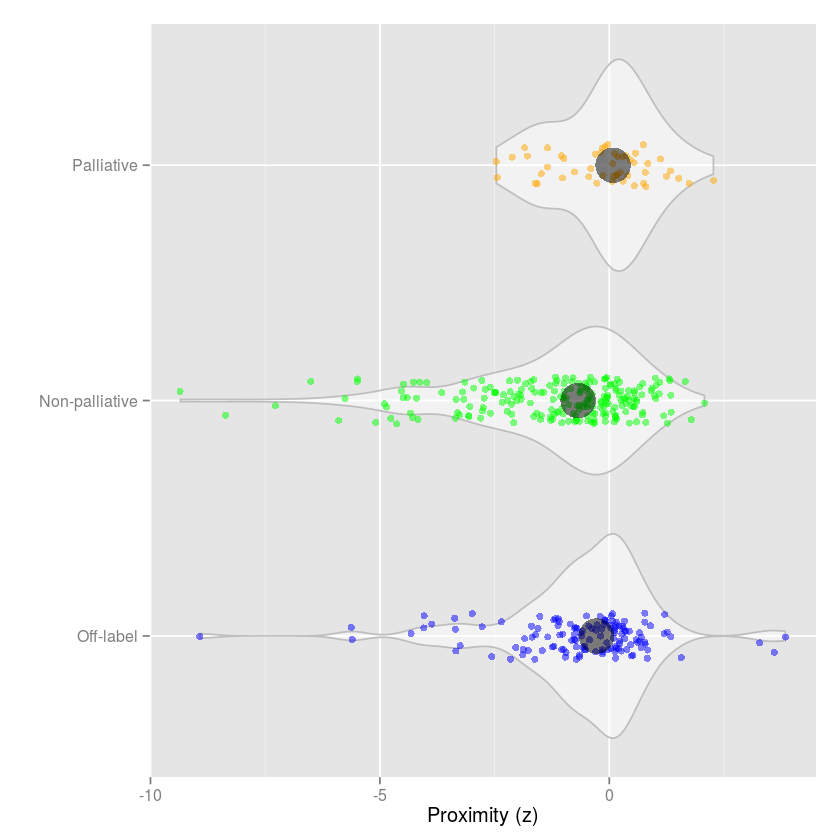

In [15]:
# Proximity and RE among palliative vs non-palliaitve and off-label
y = e[e$type=="Palliative",]
x = e[e$type=="Non-palliative",]
a = wilcox.test(x$z, y$z, alternative="less")
print(sprintf("z non-palliative ~ palliative: %.3f %.3f %s", median(x$z, na.rm=T), median(y$z, na.rm=T), a$p.value))
x = e[e$type=="Off-label",]
a = wilcox.test(x$z, y$z, alternative="less")
print(sprintf("z off-label ~ palliative: %.3f %.3f %s", median(x$z, na.rm=T), median(y$z, na.rm=T), a$p.value))

if(draw.plots) {
    # Type vs z
    #p = draw.violinplot(f, "type", "z", "", "Proximity (z)") in R_utilities at toolbox
    variable = "type"
    value = "z"
    y.lab = "Proximity (z)"
    p = ggplot(data=f, aes_string(x=variable, y=value)) + geom_violin(alpha=0.5, color="gray") 
    p = p + geom_jitter(alpha=0.5, aes_string(color=variable), position = position_jitter(width = 0.1)) 
    p = p + stat_summary(fun.y="median", geom='point', color='black', size=10, alpha=0.5) + coord_flip() 
    p = p + scale_color_manual(values=c("blue", "green", "orange"))
    p = p + labs(y = y.lab, x="") + guides(color=F) 
    print(p)
}

*** RE of proximal vs distant pairs***

[1] "RE proximal ~ distant: 77.358 71.429 0.0402451893864027"


Warning message:
: Removed 198 rows containing non-finite values (stat_ydensity).Warning message:
: Removed 198 rows containing missing values (stat_summary).Warning message:
: Removed 198 rows containing missing values (geom_point).

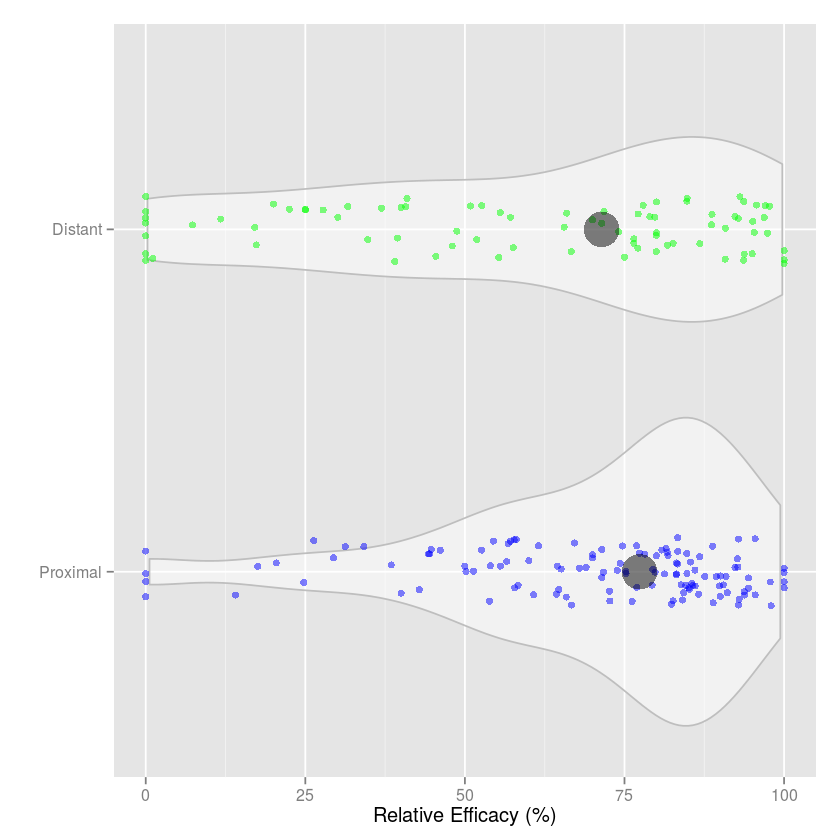

In [16]:
# RE among proximal vs distant
x = e[e$close=="Proximal",]
y = e[e$close=="Distant",]
a = wilcox.test(x$re, y$re, alternative="greater")
print(sprintf("RE proximal ~ distant: %.3f %.3f %s", median(x$re, na.rm=T), median(y$re, na.rm=T), a$p.value))

if(draw.plots) {
    # z vs RE
    e$close = factor(e$close, c("Proximal", "Distant"))
    #p = draw.violinplot(e, "close", "re", "", "Relative Efficacy (%)")
    variable = "close"
    value = "re"
    y.lab = "Relative Efficacy (%)"
    p = ggplot(data=e, aes_string(x=variable, y=value)) + geom_violin(alpha=0.5, color="gray") 
    p = p + geom_jitter(alpha=0.5, aes_string(color=variable), position = position_jitter(width = 0.1)) 
    p = p + stat_summary(fun.y="median", geom='point', color='black', size=10, alpha=0.5) + coord_flip() 
    p = p + scale_color_manual(values=c("blue", "green", "orange"))
    p = p + labs(y = y.lab, x="") + guides(color=F) 
    print(p)
}

***Proximal drugs per disease***

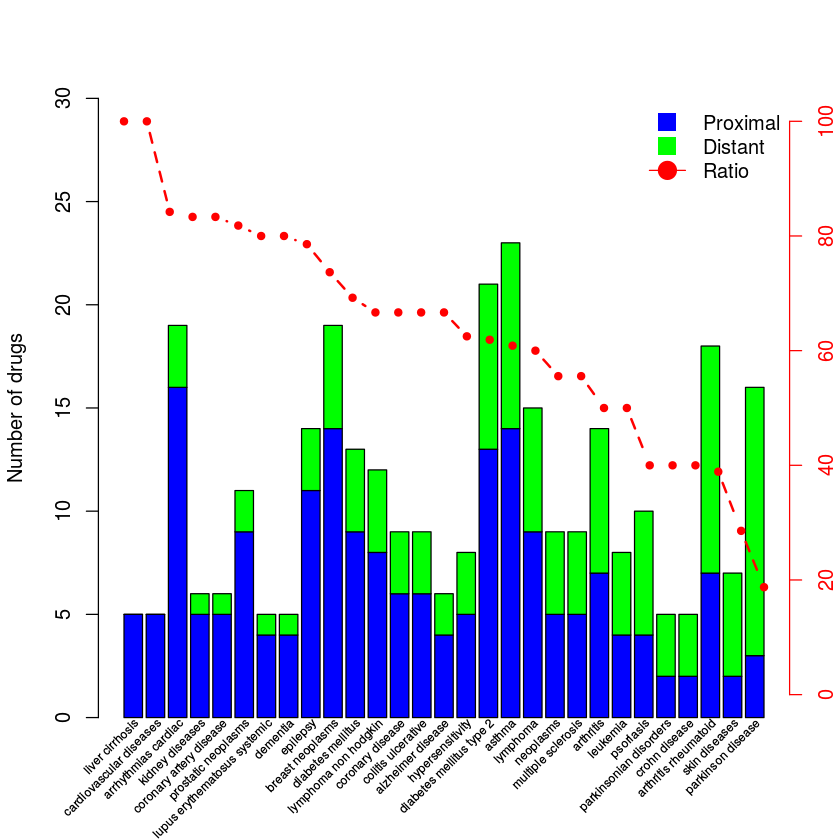

In [17]:
method = "z"
cutoff = Z.CUTOFF
n.drug.cutoff = 5

e = d[d$flag=="True",]
a = split(e$group, e$disease)
y = sapply(a, length)
f = e[e[[method]]<=cutoff,]
b = split(f$group, f$disease)
x = sapply(b, length)
f = data.frame(disease=names(y), n.known=y, n.close=x, ratio=x/y)

f = f[f$n.known >= n.drug.cutoff,]
n.max = ceiling(max(f$n.known) / 10) * 10
f = f[rev(order(f$ratio, f$n.close, f$n.known)),]

if(draw.plots) {
    #par(mar=c(12, 4, 4, 5) + 0.1)
    a<-barplot(rbind(f$n.close, f$n.known-f$n.close), beside=F, ylab="Number of drugs", xaxt="n", width=1, ylim=c(0,n.max), col=c("blue", "green"))
    x.labels = lapply(f$disease, function(x){ return(gsub("[.]", " ", x)) })

    text(a,  par("usr")[3], labels=x.labels, adj=c(1, 1), srt=45, cex=0.6, xpd=T) 
    par(new=T)

    plot(a, 100*f$n.close/f$n.known, col=2, xaxt="n", yaxt="n", xlab="", ylab="", type='b', pch=20, bty="n", lty=2, lwd=2, ylim=c(0,100))
    axis(4, xpd=T, col=2, col.axis=2)
    mtext("Ratio (%)", side=4, line=3, col=2)
    legend("topright", c("Proximal", "Distant", "Ratio"), pch=c(15, 15, 19), pt.cex=2, col=c(c("blue", "green"), 2), lty=c(0,0,1), bty="n") 
}

***Relative efficacy per disease***

Loading required package: beanplot


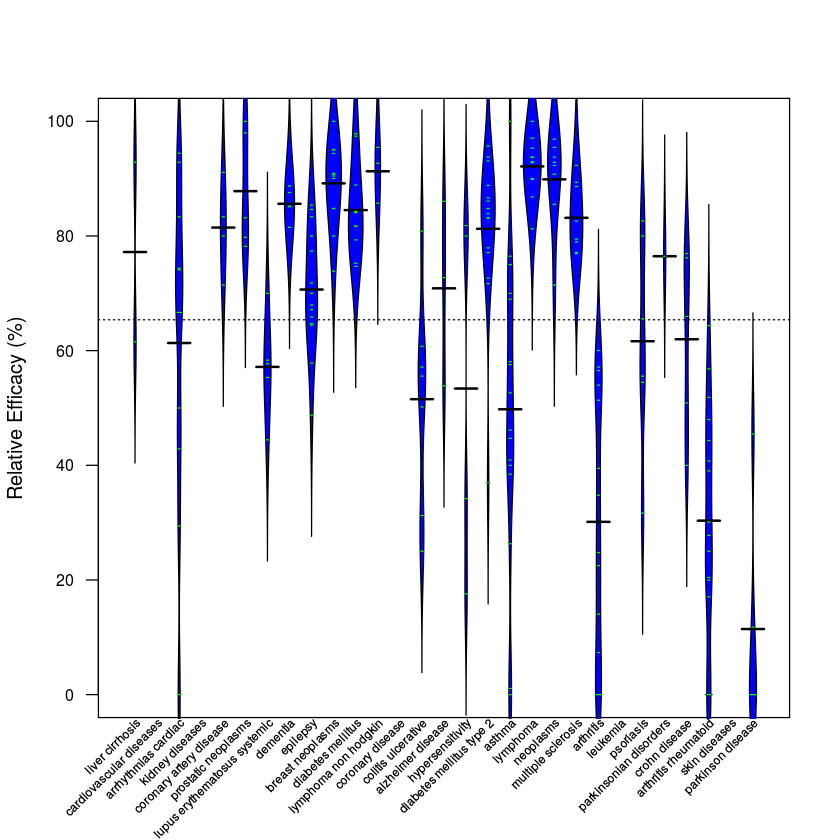

In [18]:
# Efficacy per disease violin plots
e = d[d$flag=="True",]
e$re = 100*e$re
a = split(e$group, e$disease)
y = sapply(a, length)
f = e[e$z<=cutoff,]
b = split(f$group, f$disease)
x = sapply(b, length)

idx = names(y[y>=n.drug.cutoff])
y = y[idx]
x = x[idx]

idx = rev(order(x/y, x, y))
e$disease = factor(e$disease, levels = factor(names(y[idx])))

if(draw.plots) {
    require(beanplot)
    #par(mar=c(12, 4, 4, 5) + 0.1)
    a = beanplot(re~disease, data=e, col=c("blue", "green"), ylim=c(0,100), ylab="Relative Efficacy (%)", las=2, ll=0.1, cex.axis=0.8, xaxt="n", bw='nrd0')
    x.labels = lapply(names(y[idx]), function(x){ return(gsub("[.]", " ", x)) })
    text(1:length(a$stats), par("usr")[3], labels=x.labels, adj=c(1, 1), srt=45, cex=0.6, xpd=T)
}